In [1]:
#导入必要的库
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.optimizers import Nadam

# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
# 设置随机种子
np.random.seed(1234)

# tensorflow V2.x
# For Tensorflow 2.0 tf.random.set_random_seed(seed) changed to tf.random.set_seed(seed).
tf.random.set_seed(1234)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import csv
import os
directory='/content/drive/My Drive/taidi/'
filename='week_sum.csv'
filepath=os.path.join(directory,filename)

In [5]:
# 读取数据
# df = pd.read_csv('./全部数据/order_train1.csv',parse_dates=["order_date"],index_col=[0])   # 把日期变为索引
# df = pd.read_csv('./全部数据/order_train1.csv')   
df = pd.read_csv(filepath)  

first_col = df.pop('ord_qty')
df.insert(1, 'ord_qty', first_col)  #把订单量变为第一列

display(df)  
df.info()

,order_date,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,week,item_price,brand_qty_median,lag_4,rmean_4_4
0,2015-9-1,54,20007,101,305,412,2015,9,36,98.000000,28,0,0.00
1,2015-9-1,18,20020,101,305,412,2015,9,36,1918.000000,28,0,0.00
2,2015-9-1,39,20082,101,305,412,2015,9,36,1161.500000,28,0,0.00
3,2015-9-1,388,20092,101,306,407,2015,9,36,731.000000,36,0,0.00
4,2015-9-1,66,20096,101,306,407,2015,9,36,950.000000,36,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154332,2018-12-1,85,22058,105,302,408,2018,12,51,1379.571429,24,76,69.25
154333,2018-12-1,7,22059,105,305,412,2018,12,51,453.000000,28,27,35.25
154334,2018-12-1,618,22066,105,307,403,2018,12,51,336.000000,41,102,928.00
154335,2018-12-1,248,22072,105,305,412,2018,12,51,427.000000,28,657,460.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154337 entries, 0 to 154336
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         154337 non-null  object 
 1   ord_qty            154337 non-null  int64  
 2   item_code          154337 non-null  int64  
 3   sales_region_code  154337 non-null  int64  
 4   first_cate_code    154337 non-null  int64  
 5   second_cate_code   154337 non-null  int64  
 6   year               154337 non-null  int64  
 7   month              154337 non-null  int64  
 8   week               154337 non-null  int64  
 9   item_price         154337 non-null  float64
 10  brand_qty_median   154337 non-null  int64  
 11  lag_4              154337 non-null  int64  
 12  rmean_4_4          154337 non-null  float64
dtypes: float64(2), int64(10), object(1)
memory usage: 15.3+ MB


In [6]:
testset_start = df[(df.year==2018)&(df.month==9)].index.tolist()[0]
testset_end = df[(df.year==2018)&(df.month==11)].index.tolist()[-1]
print(testset_start, testset_end)

133506 150288


In [7]:
#设置LSTM的时间窗等参数
window = 60  # 60 3 30 300
lstm_units = 200  # 100 200
dropout = 0.01  
epoch=100  # 最大epoch, 会早停
batch_size = 280  # 128 280 480
activation='tanh'

In [8]:
y = df['ord_qty']

# 数据标准化，选用min-max方法，以提高神经网络性能
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))  # scale of the output and input in the range 0–1 to match the scale of the layer of LSTM
y=scaler.fit_transform(np.array(y).reshape(-1,1)) # reshape:convert the univariate 1D array into 2D  # n行1列
print(y.shape)


(154337, 1)


In [9]:
# 拆分训练/测试集
# train_size = int(len(y) * 0.9)
# # test_size = len(df) - train_size
# df_for_training=y[0:train_size,:]
# df_for_testing=y[train_size:len(y),:1]

df_for_training=y[0:testset_start-1,:]
df_for_testing=y[testset_start:testset_end,:1]

# input_size=len(df.iloc[1,:])  # 特征数量
input_size = 1

print(df_for_training.shape)
print(df_for_testing.shape)

(133505, 1)
(16782, 1)


In [10]:
# 分X,Y
def createXY(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-window-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+window), 0]   
		dataX.append(a)
		dataY.append(dataset[i + window, 0]) #第一列为订单量
	return np.array(dataX), np.array(dataY)

time_step = window
trainX,trainY=createXY(df_for_training,window)
testX,testY=createXY(df_for_testing,window)

# reshape X
trainX = trainX.reshape(trainX.shape[0],trainX.shape[1],1)
testX = testX.reshape(testX.shape[0],testX.shape[1],1)

In [11]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
# print(trainX.shape[2])

(133444, 60, 1)
(133444,)
(16721, 60, 1)
(16721,)


In [12]:
#建立LSTM模型 训练

# 优化器
my_adam = Adam(learning_rate=0.001)
my_nadam = Nadam(learning_rate = 0.001)

inputs=Input(shape=(window, input_size))
# model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
# model=MaxPooling1D(pool_size = window)(model)#池化层
# model=Dropout(dropout)(model)#droupout层
# model=LSTM(lstm_units, activation='tanh',name='lstm')(model)#LSTM层

# 第一层LSTM，12是单元个数超参数，多层LSTM前面几层必须return_sequences=True，输入window个时间步，input_size个特征
model=Bidirectional(LSTM(lstm_units, activation=activation,return_sequences=True), name='bilstm')(inputs)#双向LSTM层
model=Dropout(dropout)(model)#droupout层
# 最后一层LSTM,return_sequences=False
model=Bidirectional(LSTM(lstm_units, activation=activation, return_sequences=False),name='bilstm2')(model)
# model=Bidirectional(LSTM(lstm_units, activation='tanh'), name='bilstm')(inputs)#双向LSTM层
# model=Dropout(dropout)(model)#droupout层 正则化
attention=Dense(lstm_units*2, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
attention=Dropout(dropout)(attention)#droupout层 正则化
model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)

model = Model(inputs=inputs, outputs=outputs)


# model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.compile(loss='mse',optimizer=my_nadam)
model.summary()#展示模型结构

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 bilstm (Bidirectional)         (None, 60, 400)      323200      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 60, 400)      0           ['bilstm[0][0]']                 
                                                                                                  
 bilstm2 (Bidirectional)        (None, 400)          961600      ['dropout[0][0]']                
                                                                                              

In [13]:
# use early stop to avoid over-fiting  早停法防止过拟合,若loss不减小，训练停止
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

# 模型训练
history=model.fit(trainX, trainY, epochs = epoch, batch_size = batch_size, shuffle=False,callbacks=[monitor], validation_data=(testX, testY)) #训练模型epoch次

Epoch 1/100
477/477 [==============================] - 46s 74ms/step - loss: 8.6367e-04 - val_loss: 7.9791e-04
Epoch 2/100
477/477 [==============================] - 34s 71ms/step - loss: 8.5111e-04 - val_loss: 7.9627e-04
Epoch 3/100
477/477 [==============================] - 33s 69ms/step - loss: 8.5713e-04 - val_loss: 7.9742e-04
Epoch 4/100
477/477 [==============================] - 33s 70ms/step - loss: 8.5046e-04 - val_loss: 7.9558e-04
Epoch 5/100
477/477 [==============================] - 33s 70ms/step - loss: 8.4891e-04 - val_loss: 7.9461e-04
Epoch 6/100
477/477 [==============================] - 34s 72ms/step - loss: 8.4894e-04 - val_loss: 7.9403e-04
Epoch 7/100
477/477 [==============================] - 33s 70ms/step - loss: 8.4903e-04 - val_loss: 7.9450e-04
Epoch 8/100
477/477 [==============================] - 33s 70ms/step - loss: 8.4883e-04 - val_loss: 7.9346e-04
Epoch 9/100
477/477 [==============================] - 33s 70ms/step - loss: 8.4659e-04 - val_loss: 7.9235e-04
E

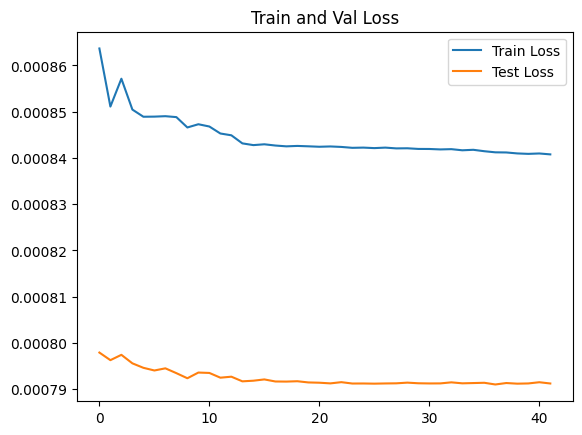

In [14]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
# epochs_range = range(epoch)
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

In [15]:
# # create the list of difference between prediction and test data
# predictions = model.predict(testX)
# len(predictions)

# # Showing the predicted vs. actual values
# fig, axs = plt.subplots()
# fig.set_figheight(8)
# fig.set_figwidth(15)

# axs.plot(testY,color='blue', label='Actual',linestyle='--',linewidth=1)
# axs.plot(predictions,color='red', label='Predicted',linewidth=1)
# # axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
# plt.title('Prediction  with standardize data')
# plt.xlabel('Time Steps')
# plt.ylabel('Order quantity (Standardized Data)')
# plt.legend(loc='upper left')
# plt.show()

# # plot_1(history1, 'Training / Validation Losses from History')

In [16]:
# # score=model.evaluate(testX,testY,verbose=0)
# # print('Test mse with Standardized Data:')
# # print(score)
# # # print('Test Loss:',score[0])
# # # print('Test mae:',score[1])

# # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
# print('----------with standarded data----------')
# print("mean_absolute_error:", mean_absolute_error(testY, predictions))
# print("mean_squared_error:", mean_squared_error(testY, predictions))
# print("rmse:", sqrt(mean_squared_error(testY, predictions)))
# print("r2 score:", r2_score(testY, predictions))


523/523 [==============================] - 5s 7ms/step
(16721, 1)


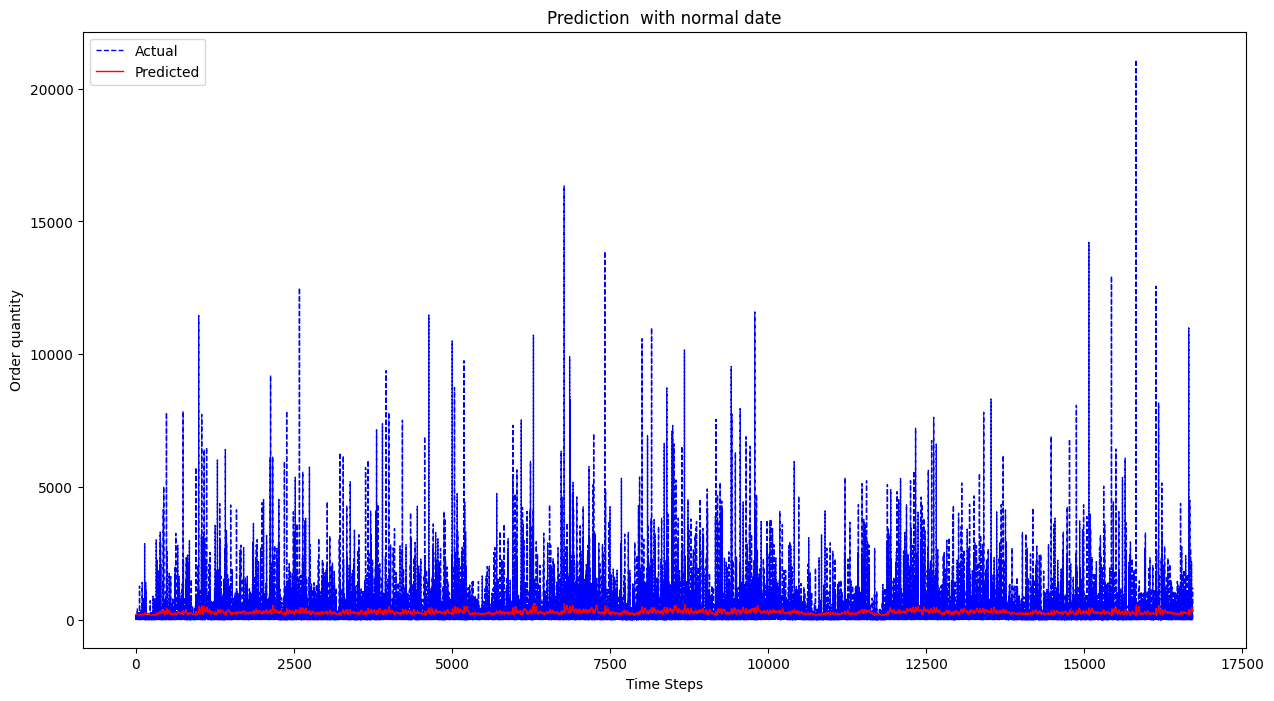

In [17]:
# 还原模型预测

# create the list of difference between prediction and test data
predictions = model.predict(testX)
print(predictions.shape)

# 反归一化
prediction_copies_array = np.repeat(predictions,testX.shape[2], axis=-1)
predictions_inv=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),testX.shape[2])))[:,0]

testY_copies_array = np.repeat(testY,testX.shape[2], axis=-1)
testY_inv=scaler.inverse_transform(np.reshape(testY_copies_array,(len(testY),testX.shape[2])))[:,0]


# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

axs.plot(testY_inv,color='blue', label='Actual',linestyle='--',linewidth=1)
axs.plot(predictions_inv,color='red', label='Predicted',linewidth=1)
# axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.title('Prediction  with normal date')
plt.xlabel('Time Steps')
plt.ylabel('Order quantity')
plt.legend(loc='upper left')
plt.show()


In [18]:

# df_test_copy = df_for_testing[0:-window-1,:]
df_test_copy = df.iloc[testset_start:testset_end-window-1,1:]
df_test_copy.insert(loc=0, column='ord_qty_pre', value = predictions_inv)
df_test_copy = df_test_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'],as_index=False).agg({'ord_qty': 'sum', 'ord_qty_pre':'sum'})
display(df_test_copy)


,year,month,sales_region_code,item_code,first_cate_code,second_cate_code,ord_qty,ord_qty_pre
0,2018,9,101,20002,303,406,45,465.430115
1,2018,9,101,20003,301,405,93,479.512939
2,2018,9,101,20006,307,403,109,441.781494
3,2018,9,101,20014,307,403,16,486.105591
4,2018,9,101,20016,303,401,930,774.570984
...,...,...,...,...,...,...,...,...
5762,2018,11,105,22059,305,412,37,555.752197
5763,2018,11,105,22066,307,403,9330,789.070190
5764,2018,11,105,22072,305,412,1185,723.481567
5765,2018,11,105,22081,303,401,15,452.488159


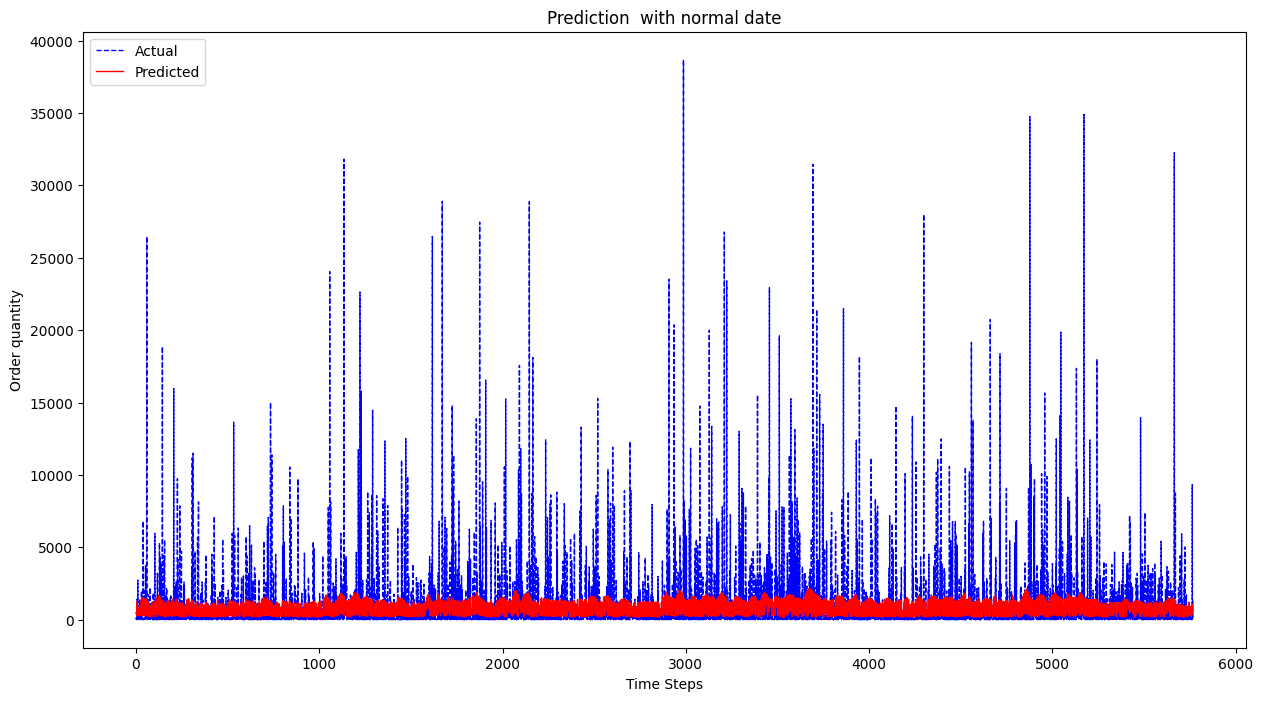

In [19]:
# 还原模型预测

# # create the list of difference between prediction and test data
# predictions = model.predict(testX)
# print(predictions.shape)

# # 反归一化
# prediction_copies_array = np.repeat(predictions,testX.shape[2], axis=-1)
# predictions_inv=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),testX.shape[2])))[:,0]

# testY_copies_array = np.repeat(testY,testX.shape[2], axis=-1)
# testY_inv=scaler.inverse_transform(np.reshape(testY_copies_array,(len(testY),testX.shape[2])))[:,0]

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

axs.plot(df_test_copy['ord_qty'],color='blue', label='Actual',linestyle='--',linewidth=1)
axs.plot(df_test_copy['ord_qty_pre'],color='red', label='Predicted',linewidth=1)
# axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.title('Prediction  with normal date')
plt.xlabel('Time Steps')
plt.ylabel('Order quantity')
plt.legend(loc='upper left')
plt.show()


In [20]:

# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
print('------------验证集-周-------------')
print("mae:", mean_absolute_error(testY_inv, predictions_inv))
print("mape:", mean_absolute_percentage_error(testY_inv, predictions_inv))
print("mse:", mean_squared_error(testY_inv, predictions_inv))
print("rmse:", sqrt(mean_squared_error(testY_inv, predictions_inv)))
print("r2:", r2_score(testY_inv, predictions_inv))

print('------------验证集-月-------------')
print("mae:", mean_absolute_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("mape:", mean_absolute_percentage_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("mse:", mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("rmse:", sqrt(mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre'])))
print("r2:", r2_score(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))

------------验证集-周-------------
mae: 381.28149736284763
mape: 13.80071199483078
mse: 712072.7014913702
rmse: 843.8440030546939
r2: 0.0010345895067517263
------------验证集-月-------------
mae: 1003.2620131252997
mape: 15.022697036465829
mse: 6167558.996303932
rmse: 2483.457065524575
r2: 0.09659974163778917
